In [1]:
import cv2
import math
import os

%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image

from utils.thresholding import *

In [2]:
WIDTH = 640
HEIGHT = 480

# Change these variables based on our car.
wheelbase = 0.1524 # Length of car from front to back in meters
n = 5 # Angle gain

curvature = 1500
is_left_turn = False

ym_per_pix = 0.1524 / 72.0
xm_per_pix = 0.2286 / 600.0
y_eval = 480

In [3]:
frame_in_w = WIDTH
frame_in_h = HEIGHT

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("capture device is open: " + str(videoIn.isOpened()))

capture device is open: True


In [112]:
test_image = Image.open(os.path.join('test_images', 'test17.jpg'))
resized_image = np.array(test_image.resize((WIDTH, HEIGHT), Image.BILINEAR))
# ret, frame_vga = videoIn.read()
# resized_image = cv2.cvtColor(frame_vga.reshape(frame_in_h, frame_in_w, 3).astype(np.uint8), cv2.COLOR_BGR2RGB)
b_thresholded = threshold(resized_image)

([], <a list of 0 Text yticklabel objects>)

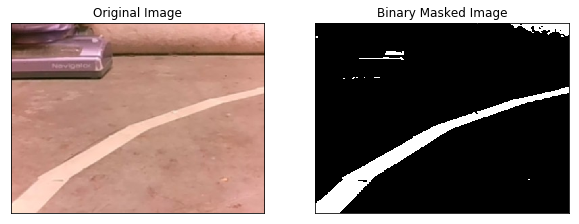

In [113]:
plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(resized_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(b_thresholded, cmap="gray")
plt.title('Binary Masked Image')
plt.xticks([])
plt.yticks([])

In [114]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size
scale_factor_h = width / 1280
scale_factor_v = height / 720
offset = 200 * scale_factor_h
src = np.float32([
    [100, 100],
    [600, 100],
    [600, 390],
    [40, 390]
])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
binary_warped = cv2.warpPerspective(b_thresholded,M, (width, height))

([], <a list of 0 Text yticklabel objects>)

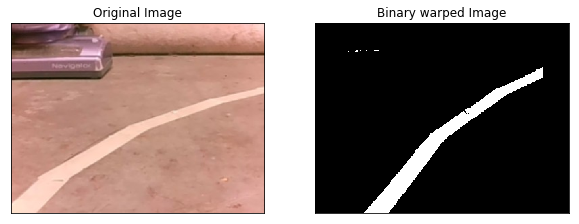

In [115]:
plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(resized_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(binary_warped, cmap="gray")
plt.title('Binary warped Image')
plt.xticks([])
plt.yticks([])

In [116]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

if leftx.size > 0 and lefty.size > 0 and rightx.size > 0 and righty.size > 0:
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    
    y_top = 0
    y_bottom = y_eval  # typically near 700

    x_top = left_fit[0]*y_top**2 + left_fit[1]*y_top + left_fit[2]
    x_bottom = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]

    is_left_turn = x_bottom > x_top
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
elif leftx.size > 0 and lefty.size > 0:
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    
    y_top = 0
    y_bottom = y_eval  # typically near 700

    x_top = left_fit[0]*y_top**2 + left_fit[1]*y_top + left_fit[2]
    x_bottom = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]

    is_left_turn = x_bottom > x_top
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
elif rightx.size > 0 and righty.size > 0:
    # Fit a second order polynomial to each
    right_fit = np.polyfit(righty, rightx, 2)

    y1 = (2*right_fit[0]*y_eval + right_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*right_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

    y_top = 0
    y_bottom = y_eval  # typically near 700

    x_top = left_fit[0]*y_top**2 + left_fit[1]*y_top + left_fit[2]
    x_bottom = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]

    is_left_turn = x_bottom > x_top
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)

In [117]:
print(curvature)

3.38043354951


In [118]:
def calculate_turn_angle(radius_of_curvature, wheelbase, angle_gain, is_left_turn):
    if radius_of_curvature == 0:
        radius_of_curvature = 1.0e-10
    
    turn_angle = math.atan(wheelbase/radius_of_curvature)
    
    if is_left_turn:
        turn_angle = -turn_angle
    
    return angle_gain * math.degrees(turn_angle)

angle = calculate_turn_angle(curvature, wheelbase, n, is_left_turn)
print(angle)

12.906581509611868


Text(0.5,1,'Lane Detected')

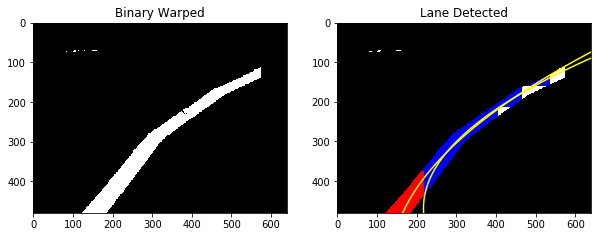

In [119]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 640)
plt.ylim(480, 0)
plt.title('Lane Detected')